# Twitter Sentiment Analysis to predict outcome of the 2020 US presidential elections

# Team Members
Abhishek Bais, Wasae Qureshi, Samer Baslan

# Import packages

In [ ]:
# Import standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import string, collections, unicodedata
import missingno as msno

# Import NLP libraries
import re
import nltk
import json
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import subjectivity

# Import models, evaluator libraries
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

# Import location, time libraries
import os
import time
from datetime import datetime, timedelta

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
!pip install langdetect


     |████████████████████████████████| 983kB 5.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=270e2a2cb3d38b1c8772d25027085b20a74a167e11bf9c67c16a1fd83e21fab6
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [ ]:
!pip install geopandas

     |████████████████████████████████| 972kB 4.2MB/s 
     |████████████████████████████████| 6.5MB 28.3MB/s 
     |████████████████████████████████| 14.8MB 315kB/s 


In [ ]:
# Mount Google Drive
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


# Read in tweets referencing Joe Biden and Donald Trump

In [ ]:
# Read in tweets referencing Joe Biden and Donald Trump
df_biden = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
df_trump = pd.read_csv('/content/drive/My Drive/255/datasets/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)
#data = data_d.append(data_j, ignore_index=True)

In [ ]:
# Report the number of entries in biden dataset
df_biden.shape

(776886, 21)

In [ ]:
# Report Biden data
df_biden.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [ ]:
# Inspect biden data for missing entries
df_biden.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     713
user_id                      0
user_name                   18
user_screen_name             0
user_description         82006
user_join_date               0
user_followers_count         0
user_location           233791
lat                     421593
long                    421593
city                    590014
country                 423107
continent               423089
state                   516691
state_code              532277
collected_at                 0
dtype: int64

In [ ]:
# Report the number of entries in trump dataset
df_trump.shape

(970919, 21)

In [ ]:
# Report Trump data
df_trump.head(5)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [ ]:
# Inspect trump data for missing entries
df_trump.isnull().sum()

created_at                   0
tweet_id                     0
tweet                        0
likes                        0
retweet_count                0
source                     876
user_id                      0
user_name                   16
user_screen_name             0
user_description        101266
user_join_date               0
user_followers_count         0
user_location           294953
lat                     525200
long                    525200
city                    743732
country                 528171
continent               528154
state                   650299
state_code              670494
collected_at                 0
dtype: int64

# Data pre-processing

In [ ]:
# Read in the common word phrases
with open('/content/drive/My Drive/256/256_common_word_phrases.json', 'r') as f:
    phrases_dict = json.load(f)
phrases = phrases_dict['phrases']
phrases

{"'cause": 'because',
 "ain't": 'am not / are not',
 "aren't": 'are not / am not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he had / he would',
 "he'd've": 'he would have',
 "he'll": 'he shall / he will',
 "he'll've": 'he shall have / he will have',
 "he's": 'he has / he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how has / how is',
 "i'd": 'I had / I would',
 "i'd've": 'I would have',
 "i'll": 'I shall / I will',
 "i'll've": 'I shall have / I will have',
 "i'm": 'I am',
 "i've": 'I have',
 "isn't": 'is not',
 "it'd": 'it had / it would',
 "it'd've": 'it would have',
 "it'll": 'it shall / it will',
 "it'll've": 'it shall have / it will have',
 "it's": 'it has / it is',
 "let's": 'l

In [ ]:
# Use custom stop words as some stop words such as no contain sentiments
stop_words = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves",
             "you", "your", "yours", "yourself", "yourselves", "he", "him",
             "his", "himself", "she", "her", "hers", "herself", "it", "its",
             "itself", "they", "them", "their", "theirs", "themselves", "what",
             "which", "who", "whom", "this", "that", "these", "those", "am", "is",
             "are", "was", "were", "be", "been", "being", "have", "has", "had",
             "having", "do", "does", "did", "doing", "a", "an", "the", "and",
             "but", "if", "or", "because", "as", "until", "while", "of", "at",
             "by", "for", "with", "about", "against", "between", "into", "through",
             "during", "before", "after", "above", "below", "to", "from", "up",
             "down", "in", "out", "on", "off", "over", "under", "again", "further",
             "then", "once", "here", "there", "when", "where", "why", "how", "all",
             "any", "both", "each", "few", "more", "most", "other", "some", "such",
             "only", "own", "same", "so", "than", "too", "very",
             "can", "will", "just", "should", "now", "not"}

In [ ]:
# Pre-process emojis
def preprocess_emojis(text):
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negative ', text) # Sad
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' negative ', text)                  # Weep
    text = re.sub(r'(<3|:\*)', ' positive ', text)                           # Love
    text = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positive ', text)            # Wink
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positive ', text)              # Laughs
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positive ', text) # Smileys
    return text

In [ ]:
# Pre-process tweet
def preprocess_text(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    return text

In [ ]:
# Custom lemmatize and split text into words for ngram visualization
def custom_lemmatize(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  wnl = WordNetLemmatizer()
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stop_words and len(word)>3]

In [ ]:
# Clean the tweet for ngram visualization
def clean_tweet(text):
    preprocess_text(text)
    cleaned_text=""
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    text = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',text)
    words=text.split()
    for word in words:
        if word not in stop_words:
            cleaned_text=cleaned_text+' '+word
    return cleaned_text

In [ ]:
# Custom lemmatize and recreate text for sentiment analysis
def custom_lemmatize_and_join(text):
  text = (unicodedata.normalize('NFKD', text)
         .encode('ascii', 'ignore')
         .decode('utf-8', 'ignore')
         .lower())
  lemmatizer = WordNetLemmatizer()
  word_list = text.split()        
  text = ' '.join([lemmatizer.lemmatize(w) for w in word_list if not w in stop_words and len(w)>3])   
  return text

In [ ]:
# Pre-process tweet to prepare clean, lemma tweet for sentiment analysis
def preprocess_tweet(text):
    preprocess_emojis(text)
    text = text.lower()                                             # To lower
    text = re.sub(r"\d+", " ", str(text))                           # Delete numbers
    text = re.sub('&quot;'," ", text)                               # Delete &quot;
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)   # Delete link
    text = re.sub('@[^\s]+', '', text)                              # Delete user info
    text = re.sub(r"\b[a-zA-Z]\b", "", str(text))                   # Delete one chars
    text = re.sub(r"[^\w\s]", " ", str(text))                       # Delete punctuations
    text = re.sub(r"\s+", " ", str(text))                           # Clean double space
    text = re.sub(r'(.)\1+', r'\1\1', text)                         # Clean multiple repeats
    for word in text.split():
        if word.lower() in phrases:
            text = text.replace(word, phrases[word.lower()])        # Swap common word phrases
    custom_lemmatize_and_join(text)
    return text

# Clean, Lemma Biden tweets

In [ ]:
# Clean, Lemma, vectorize the Biden tweets
df_biden['preprocessed_tweet'] = df_biden.tweet.apply(preprocess_tweet)

In [ ]:
# Report original and clean, lemma, stemmed Biden tweets
pd.set_option('display.max_colwidth', 0)
df_biden.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,hunterbiden hunterbidenemails joebiden joebidenmuststepdown enmxwvepm
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,this is how biden made his trumpisnotamerica ip


# Clean, Lemma Trump tweets

In [ ]:
# Clean, Lemma the Trump tweets
df_trump['preprocessed_tweet'] = df_trump.tweet.apply(preprocess_tweet)

In [ ]:
# Report original and clean, lemma, stemmed Trump tweets
pd.set_option('display.max_colwidth', 0)
df_trump.head(3)

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,preprocessed_tweet
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,elecciones en florida joebiden dice que donaldtrump solo se preocupa por él mismo el demócrata fue anfitrión de encuentros de electores en pembrokepines miramar clic aquí _ elsollatino yobrilloconelsol flcbwf mi
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,usa trump contro facebook twitter coprono biden donaldtrump ceurhe vp jidljoon
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,trump as student used to hear for years for ten years heard china in and we have and they don know how many we have and asked them how many do we have and they said sir we don know but we have millions like million um what


# Data exploration

# Visualize tweet origin

In [ ]:
# Get the location of the tweet origin
import geopandas as gpd
world=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely.geometry import Point

df_location=pd.concat([df_trump[['lat','long']].copy(),df_biden[['lat','long']].copy()])
df_location=df_location.dropna()
geometry = [Point(xy) for xy in zip(df_location['long'],df_location['lat'])]
geo_df=gpd.GeoDataFrame(df_location, geometry = geometry)

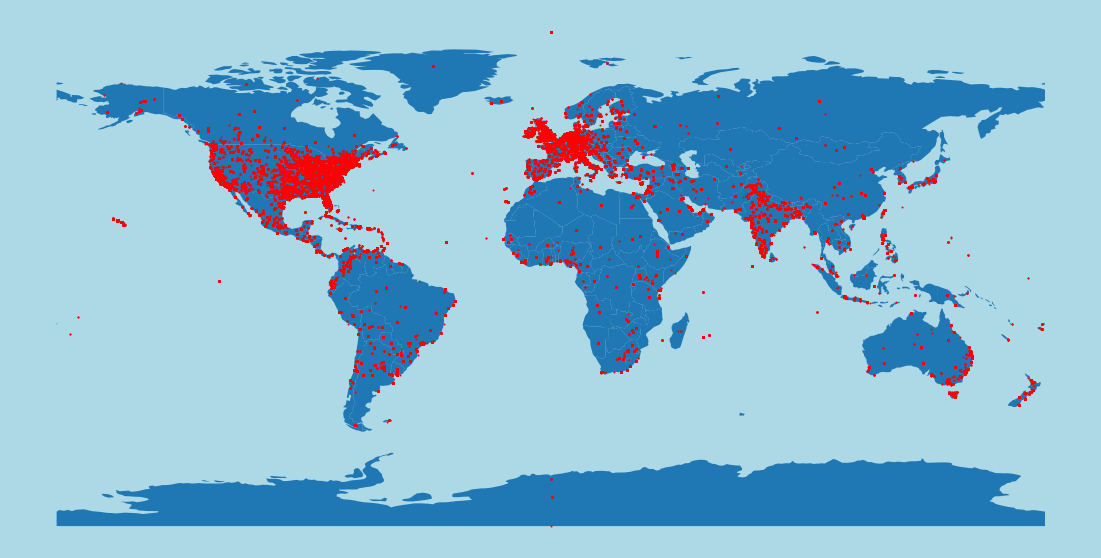

In [ ]:
# Plot the location of the tweet origin
fig, ax = plt.subplots(1,figsize=(20,10), facecolor='lightblue')
world.plot(ax=ax)
geo_df.plot(ax=ax, color='r', markersize=1)
ax.axis('off')
plt.show()

In [ ]:
# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
df_biden['collected_at']=pd.to_datetime(df_biden['collected_at'])
df_trump['collected_at']=pd.to_datetime(df_trump['collected_at'])
df_biden['created_at']=pd.to_datetime(df_biden['created_at'])
df_trump['created_at']=pd.to_datetime(df_trump['created_at'])

# create additional date time columns
df_biden['created_at_r']=df_biden['created_at'].dt.strftime('%Y-%m-%d %H')
df_trump['created_at_r']=df_trump['created_at'].dt.strftime('%Y-%m-%d %H')
df_biden['created_at_r2']=df_biden['created_at'].dt.strftime('%m-%d')
df_trump['created_at_r2']=df_trump['created_at'].dt.strftime('%m-%d')

In [ ]:
from matplotlib.ticker import FuncFormatter
@plt.FuncFormatter
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')


In [ ]:
# Visualisation args
from matplotlib import cm
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)

def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm 

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)
def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

# Visualize tweet source 

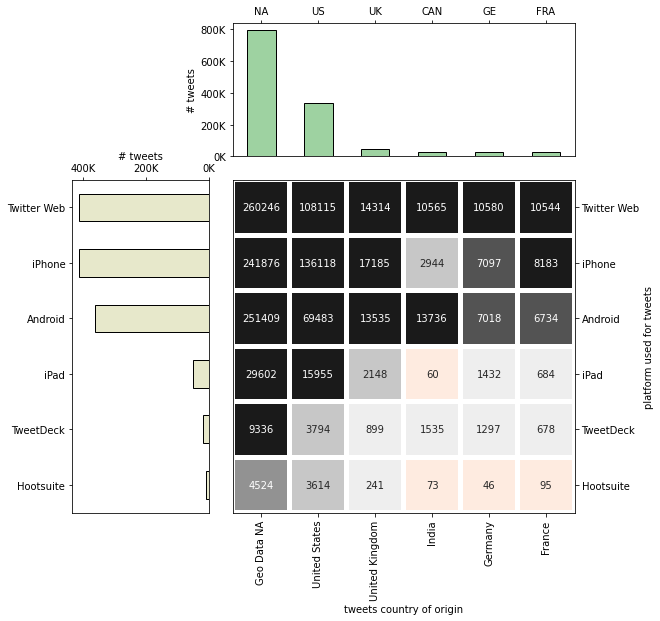

In [ ]:
source_df=pd.concat([df_biden[['source','tweet','country']].copy(),df_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
#source_df=source_df.dropna()
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0) 

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0) 
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[2],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0) 
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

In [ ]:
%%time
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([df_biden[['tweet','country']].copy(),df_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 31.7 s, sys: 219 ms, total: 32 s
Wall time: 32 s


In [ ]:
%%time
from langdetect import detect
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([df_biden[['tweet','country']].copy(),df_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

CPU times: user 33.2 s, sys: 264 ms, total: 33.5 s
Wall time: 33.6 s


# Visualize tweet language

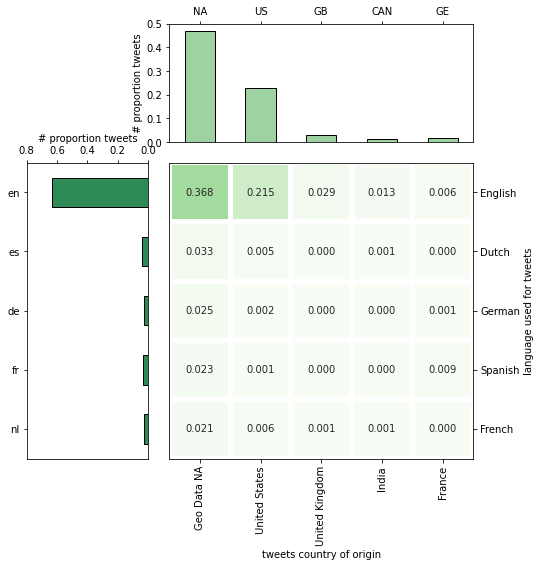

In [ ]:
fig, ax=plt.subplots(2,2, figsize=(8,8), 
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0) 
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE', 'FRA'), rotation=0) 
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0) 

plt.show()


In [ ]:
# Obtain tweets only from data that has Geo Data from the US
text1=df_biden.loc[df_biden['country'] == 'United States of America']['tweet']
text2=df_trump.loc[df_trump['country'] == 'United States of America']['tweet']

In [ ]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
words1 = custom_lemmatize(''.join(str(text1.apply(clean_tweet).tolist())))
words2 = custom_lemmatize(''.join(str(text2.apply(clean_tweet).tolist())))

biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])


# Visualize the bi, tri-gram of all USA tweets

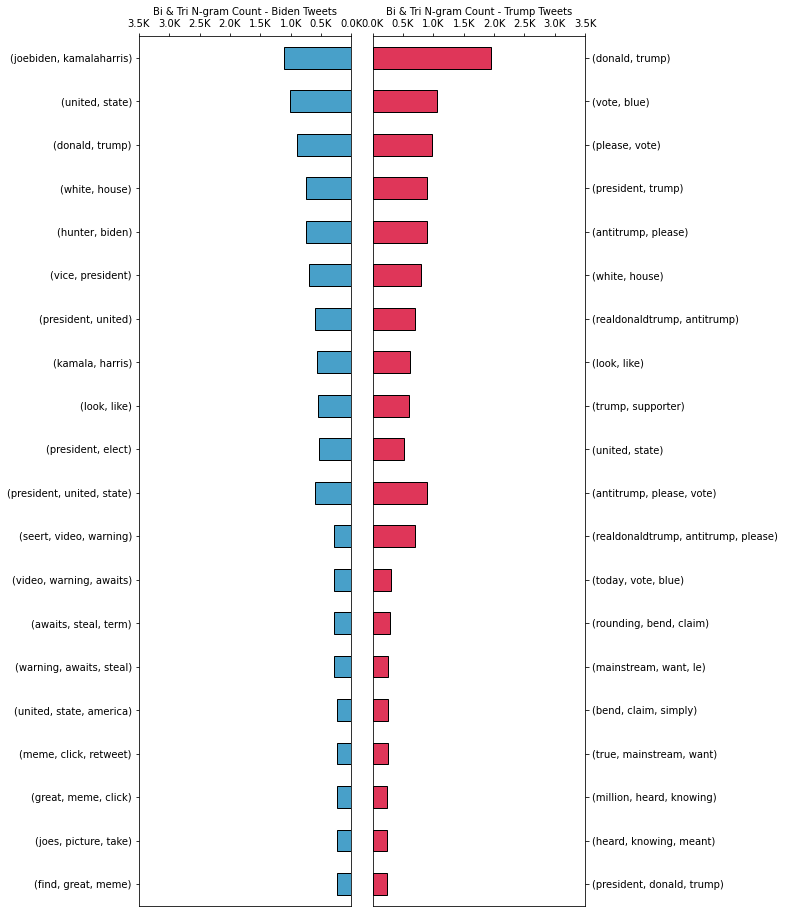

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(8,16), 
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[3],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Tweets')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color=barcolors[6],**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Tweets')
barh_ax.set_ylabel('')
plt.show()

# Word cloud of Biden tweets

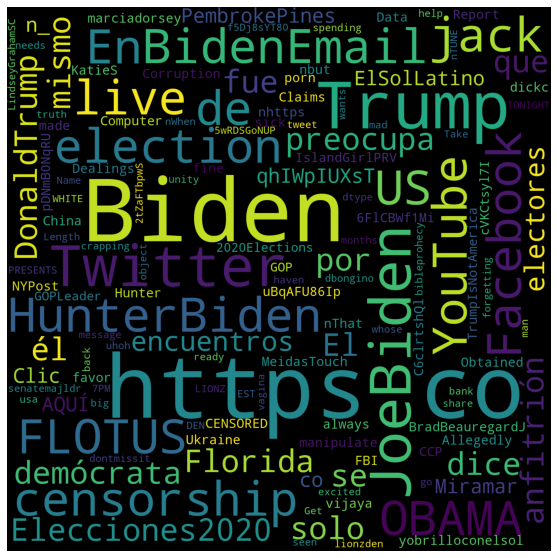

In [ ]:
# Plot word cloud of Biden tweets
plt.figure(figsize=(10,10))
wordcloud_biden = WordCloud(stopwords=stop_words, 
                    background_color="black", max_words=2500,
                    max_font_size=256, random_state=101,
                    width=1600, height=1600).generate(str(text1.dropna()))
plt.imshow(wordcloud_biden)
plt.axis("off")
plt.show()

# Word cloud of Trump tweets

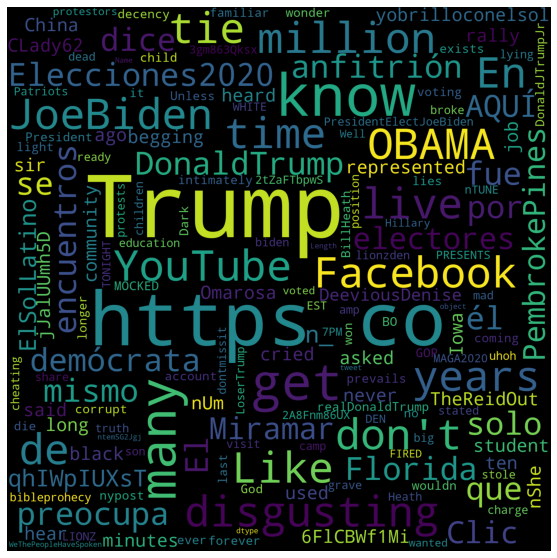

In [ ]:
# Plot word cloud of Trump tweets
plt.figure(figsize=(10,10))
wordcloud_trump = WordCloud(stopwords=stop_words, 
                    background_color="black", max_words=2500,
                    max_font_size=256, random_state=101,
                    width=1600, height=1600).generate(str(text2.dropna()))
plt.imshow(wordcloud_trump)
plt.axis("off")
plt.show()

In [ ]:
# normalise likes and retweets to allow fair analysis
b_tdiff=(df_biden['collected_at'] - df_biden['created_at'])
t_tdiff=(df_trump['collected_at'] - df_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)
b_tdiff = b_tdiff/24
t_tdiff = t_tdiff/24

# Use numpy vectorisation to create new columns for normalised likes and retweets
df_biden['likes_norm'] = normalise(df_biden['likes'],b_tdiff)
df_biden['retweet_norm'] = normalise(df_biden['retweet_count'],b_tdiff)
df_trump['likes_norm'] = normalise(df_trump['likes'],t_tdiff)
df_trump['retweet_norm'] = normalise(df_trump['retweet_count'],t_tdiff)

# Visualize Biden, Trump tweet likes per day

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


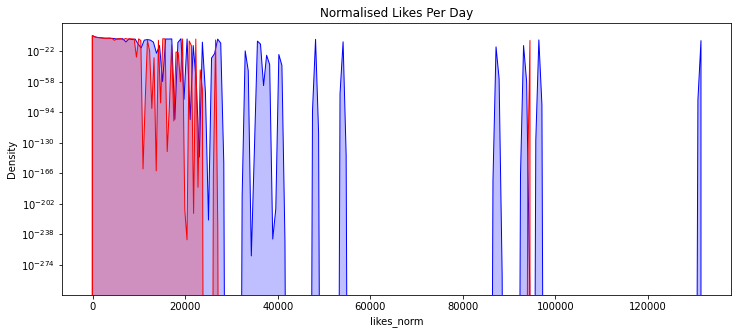

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Normalised Likes Per Day')
sns.kdeplot(df_biden['likes_norm'],bw=0.1, shade=True, color='b', label='Biden Likes', ax=line_ax)
sns.kdeplot(df_trump['likes_norm'],bw=0.1, shade=True, color='r', label='Trump Likes', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

# Visualize Biden, Trump retweet likes per day

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


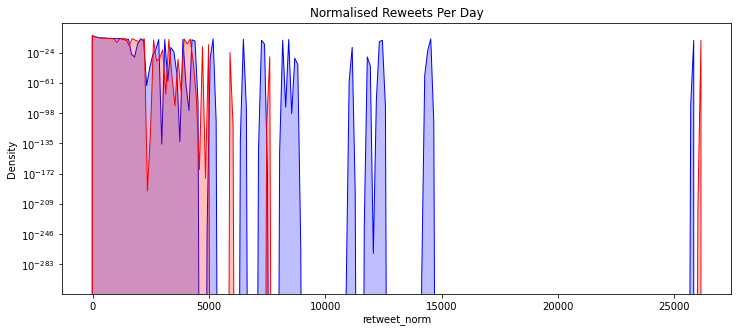

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Normalised Reweets Per Day')
sns.kdeplot(df_biden['retweet_norm'],bw=0.1, shade=True, color='b', label='Biden Retweets', ax=line_ax)
sns.kdeplot(df_trump['retweet_norm'],bw=0.1, shade=True, color='r', label='Trump Retweets', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

# Perform Sentiment analysis

In [ ]:
def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

In [ ]:
# Obtain sentiment scores for both datasets
sid = SentimentIntensityAnalyzer()
df_biden['VADAR']=sentiment(df_biden['preprocessed_tweet'])
df_trump['VADAR']=sentiment(df_trump['preprocessed_tweet'])
df_biden['compound']  = df_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
df_trump['compound']  = df_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
df_trump['sentiment']  = df_trump['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
df_biden['sentiment']  = df_biden['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

# Evaluate the sentiment analysis



# Use bag of words, TF/IDF techniques to extract feature set

In [ ]:
# Extract features using the selected method
# method 0: TF/IDF max 15,000 features
# method 1: TF/IDF use ngrams
# method 2: Count Vectorize
def extract_features(df, method):
  if (method == 0):
    features = TfidfVectorizer(max_features=10000) # shape (28665, 15000)
    X = features.fit_transform(df['preprocessed_tweet'].tolist()).toarray()
  elif (method == 1):
    features = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
    X = features.fit_transform(df['preprocessed_tweet'])
  elif (method == 2):  
    features = CountVectorizer(ngram_range=(1,2))    # Unigram, Bigram
    X = features.fit_transform(df['preprocessed_tweet'])  
  return X

# Extract features

In [ ]:
# Extract features given the method
#method = 0                                           # TF/IDF max features 15k
#method = 1                                           # TF/IDF ngrams
method = 2                                            # Use CountVectorize
#df_biden_NA = df_biden[df_biden.loc[df_biden['country'] == 'United States of America']]
#df_trump_NA = df_trump[df_trump.loc[df_trump['country'] == 'United States of America']]

df_merged=pd.concat([df_trump,df_biden])
X = extract_features(df_merged, method)
X.shape

(1747805, 8017308)

# Create training/ validation split of tweets

In [ ]:
# Split the dataset into training and validation sets - 80/20 splits
y = pd.get_dummies(df_merged['sentiment'])
y = y.iloc[:,1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101, stratify=y)

# Evaluate the sentiment analysis using Naive Bayes Model

In [ ]:
# Train and predict using Naive Bayes model on the dataset
naive_bayes = MultinomialNB().fit(X_train, y_train)
y_pred = naive_bayes.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")

print(confusion_matrix(y_test, y_pred))
print("\n")

print(classification_report(y_test, y_pred))

0.8199713354750673


[[181050  21195]
 [ 41736 105580]]


              precision    recall  f1-score   support

           0       0.81      0.90      0.85    202245
           1       0.83      0.72      0.77    147316

    accuracy                           0.82    349561
   macro avg       0.82      0.81      0.81    349561
weighted avg       0.82      0.82      0.82    349561



In [ ]:
# Train and predict using Naive Bayes model with 10 fold cross validation
naive_bayes_cv = MultinomialNB()
nfold = KFold(n_splits=10, random_state=101, shuffle=True)
scores = cross_val_score(naive_bayes_cv, X, y, cv=nfold)
print(scores)
print(scores.mean())

[0.8209588  0.82139363 0.8224807  0.82070133 0.81932819 0.81922417
 0.82007095 0.82047717 0.8202197  0.82076325]
0.8205617891848856


# Evaluate the sentiment analysis using Logistic Regression Model

In [ ]:
# Train and predict using Logistic model on the dataset
clf = LogisticRegression(solver='liblinear').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.968406086491342


[[195205   7040]
 [  4004 143312]]


              precision    recall  f1-score   support

           0       0.98      0.97      0.97    202245
           1       0.95      0.97      0.96    147316

    accuracy                           0.97    349561
   macro avg       0.97      0.97      0.97    349561
weighted avg       0.97      0.97      0.97    349561



In [ ]:
# Logistic with 10 fold cross validation
logreg = LogisticRegression(solver='liblinear')
kfold = KFold(n_splits=10, random_state=42, shuffle=True)
scores = cross_val_score(logreg, X, y, cv=kfold)
print(scores)
print(scores.mean())

# Visualize the model evaluations on the ROC/AUC curve

In [ ]:
# Visualize the Naive Bayes, Logistic Regression model performance
models = [LogisticRegression(solver='liblinear'), MultinomialNB()]

# Capture results
collated_results = pd.DataFrame(columns=['models', 'fpr','tpr','auc'])

# Iteratively capture results for different models
for model in models:
    m = model.fit(X_train, y_train)
    yproba = m.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    collated_results = collated_results.append({'models':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Index models by name
collated_results.set_index('models', inplace=True)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Plot the ROC curve for Naive Bayes, Logistic regression models on training data
fig = plt.figure(figsize=(10,8))

# Create collated ROC curves
for k in collated_results.index:
    plt.plot(collated_results.loc[k]['fpr'], 
             collated_results.loc[k]['tpr'], 
             label="{}, AUC={:.3f}".format(k, collated_results.loc[k]['auc']))
   
# Draw the plots
plt.plot([0,1], [0,1], color='blue', linestyle='-')
plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)
plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)
plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.show()

# Sentiment driven predictions for the 2020 US presidential elections 

# Sentiment Visualization

In [ ]:
# Calculate counts of sentiments
states=set(df_biden.loc[df_biden['country'] == 'United States of America']['state'].dropna())
states.remove('District of Columbia')
states.remove('Northern Mariana Islands')

df_biden['voting_rights']=df_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
df_trump['voting_rights']=df_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=df_trump.loc[df_trump['voting_rights'] == 'Yes']
sent_b=df_biden.loc[df_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 30 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(30)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(30)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

stack_t=sent_t.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()
stack_b=sent_b.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()

# Setup np.arrays to allow quick calculations of the proportions of tweet sentiments
a1=np.array(stack_b.loc[stack_b.sentiment == 'pos']['tweet'].tolist())
b1=np.array(stack_b.loc[stack_b.sentiment == 'neg']['tweet'].tolist())
c1=np.array(stack_b.loc[stack_b.sentiment == 'neu']['tweet'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['tweet'].sum().tolist())

a2=np.array(stack_t.loc[stack_t.sentiment == 'pos']['tweet'].tolist())
b2=np.array(stack_t.loc[stack_t.sentiment == 'neg']['tweet'].tolist())
c2=np.array(stack_t.loc[stack_t.sentiment == 'neu']['tweet'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['tweet'].sum().tolist())

# Calculate sentiment proportions and feed into dataframes for visualisation
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'pos':a1/d1, 'neg':b1/d1,'neu':c1/d1})

SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'pos':a2/d2,'neg':b2/d2,'neu':c2/d2})

# Visualize sentiment changes for Biden, Trump tweets over time

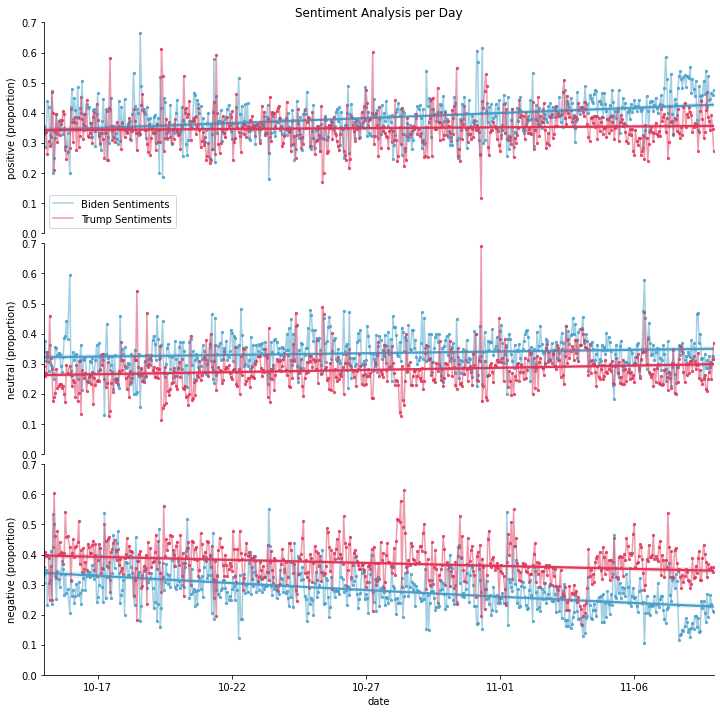

In [ ]:
import seaborn as sns
fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})
 
# Plot
lineax=ax[0]
lineax.set_title('Sentiment Analysis per Day')
sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Sentiments')
sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Sentiments')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)
lineax1=ax[1]
sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()

In [ ]:
def plot_mean_sentiment(states_sent):
  fig, ax=plt.subplots(2,1, figsize=(12,10), gridspec_kw={'hspace':0.05})
  lineax=ax[0]
  sns.lineplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax, label='Trump Tweets (L30D)')
  sns.scatterplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax)
  sns.lineplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax, label='Trump Tweets (F30D)')
  sns.scatterplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax)
  lineax.set_ylim([-0.2, 0.2])
  lineax.set_ylabel('mean sentiment score (Last 14D Data)')
  lineax.set_xlabel('')
  plt.xticks(rotation=90)
  lineax.axhline(y=0, color='k', linestyle='-')
  lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
  lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
  lineax.axes.get_xaxis().set_ticks([])
  lineax.spines['right'].set_visible(False)
  lineax.spines['top'].set_visible(False)
  lineax.spines['bottom'].set_visible(False)

  lineax=ax[1]
  sns.lineplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax, label='Biden Tweets (L30D)')
  sns.scatterplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax)
  sns.lineplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax, label='Biden Tweets (F30D)')
  sns.scatterplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax)
  lineax.set_ylim([-0.2, 0.2])
  lineax.set_ylabel('mean sentiment score')
  lineax.set_xlabel('')
  plt.xticks(rotation=90)
  lineax.axhline(y=0, color='k', linestyle='-')
  lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
  lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
  lineax.spines['right'].set_visible(False)
  lineax.spines['top'].set_visible(False)
  plt.show()


# Visualize mean sentiment score of Biden, Trump tweets for all states

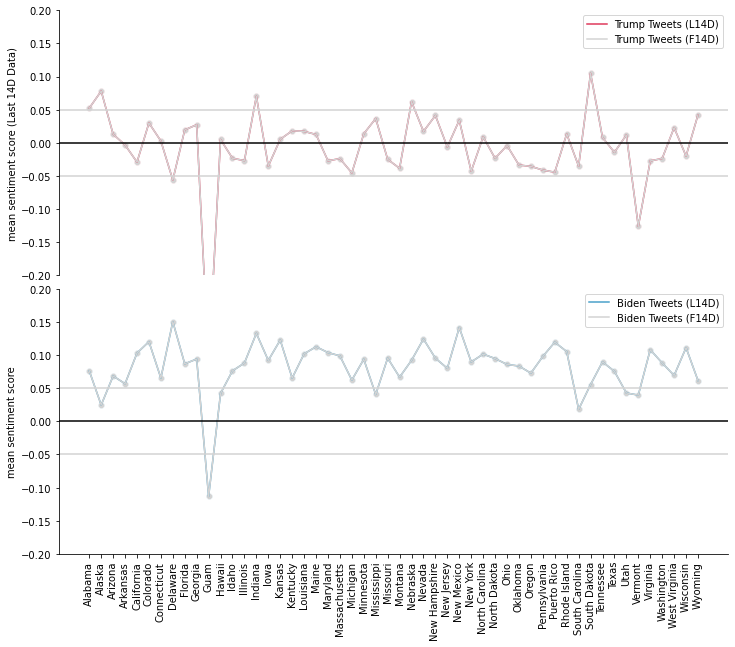

In [ ]:
# Plot mean sentiment score for all states
states=set(df_biden.loc[df_biden['country'] == 'United States of America']['state'].dropna())
states.remove('District of Columbia')
states.remove('Northern Mariana Islands')

# Create feature to allow masking of data and then mask data for votable states
df_biden['voting_rights']=df_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
df_trump['voting_rights']=df_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=df_trump.loc[df_trump['voting_rights'] == 'Yes']
sent_b=df_biden.loc[df_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 1 month
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(30)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(30)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})
plot_mean_sentiment(states_sent)

# Visualize mean sentiment score of Biden, Trump tweets for swing states

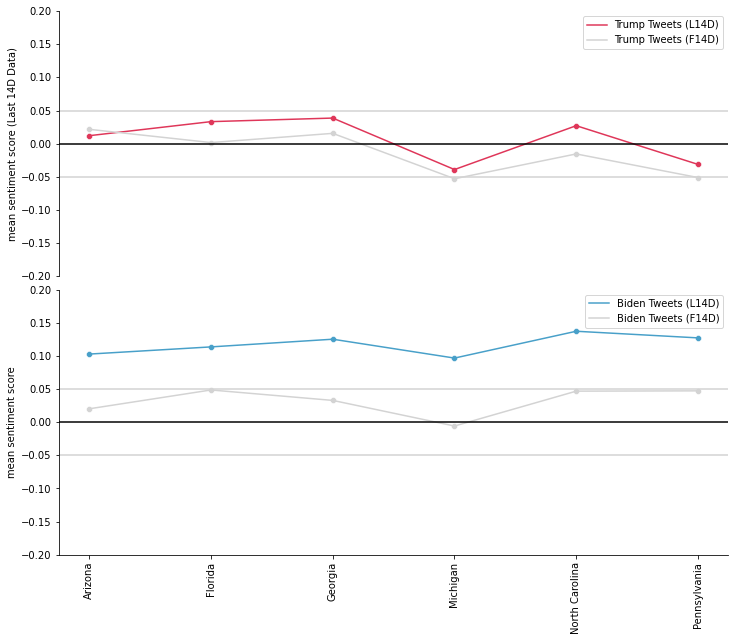

In [ ]:
# Plot mean sentiment score for swing states
swing_states=set()
swing_states.add("Arizona")
swing_states.add("Florida")
swing_states.add("Georgia")
swing_states.add("Michigan")
swing_states.add("North Carolina")
swing_states.add("Pennsylvania")

# Create feature to allow masking of data and then mask data for votable states
df_biden['voting_rights']=df_biden['state'].apply(lambda x: 'Yes' if x in swing_states else 'No')
df_trump['voting_rights']=df_trump['state'].apply(lambda x: 'Yes' if x in swing_states else 'No')
sent_t=df_trump.loc[df_trump['voting_rights'] == 'Yes']
sent_b=df_biden.loc[df_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 14 days
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(14)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(14)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Further mask data for only the last 14 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(14)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(14)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})

plot_mean_sentiment(states_sent)